SVM分類器的原理是利用“超平面”來實現數據分類, 如果今天要分類的是圖片的話,<br> 
需要先找出屬於這個類別的圖片特徵e.g.分類貓狗,先分別找出貓跟狗的特徵後,再依此分類<br><br>
HOG（Histogram of Oriented Gradient 方向梯度直方圖）<br>
是SVM常用來找圖片特徵的方式, 通過計算和統計圖像局部區域的梯度方向直方圖來構成特徵。<br>

訓練步驟如下:

1.設定引數<br>
2.建立Hog：使用cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,Bin)函式來建立<br>
3.建立svm，使用cv2.ml.SVM_create()函式來建立，並設定屬性<br>
4.計算Hog，準備標籤label<br>
5.訓練<br>
6.預測<br>
7.繪圖<br>

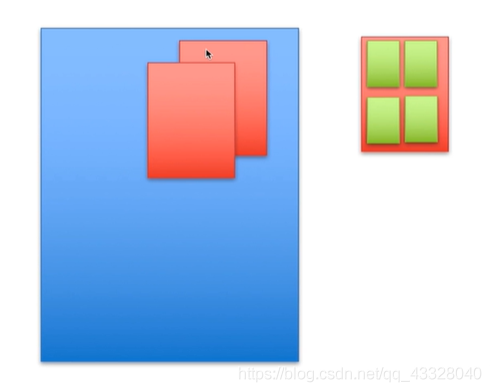

這裡有一個**影像img(整個白色區域)**, <br>
**win視窗(藍色區域)**為影象中Hog特徵計算的最大模板，官方模板大小為64x128。<br>
**block(紅色區域部分)**為win視窗中的小模板,大小一般為16x16。<br>
block中又有很多的**小模板cell(綠色區域)**，大小一般為8x8。<br>
<br>
cell bin: 通過計算畫素的梯度得到梯度的大小和方向, 方向為0-360度, 如果以40度進行劃分，將會得到9塊，將這9塊設定為9個單元，每一個單元就是一個bin。<br>
<br>
hot特徵維度: win視窗中block模板的個數 x cell模板個數 x bin的個數<br>
<br>
hog特徵： 畫素都有一個梯度，win視窗中所有的畫素梯度構成了hog特徵<br>
<br>
如何計算梯度：<br>
我們使用倆個模板:水平梯度模板[1 0 -1], 豎直梯度模板[[1],[0],[-1]],即相鄰畫素之差。求得幅值為：f = sqrt(x^2 + y^2),角度angle = arctan(a / b)<br>
<br>
bin的劃分：如果以40度進行劃分，將會得到9個bin，則bin1的區域為(0-20度)和180-200度,即關於180度對稱的夾角<br>
<br>
如果某個梯度的角度正好在bin角度範圍的正中心, 如d = 10,則將其規劃到bin1區域。否則將該梯度分解到相鄰的倆個bin單元中：d1 = d x d(夾角), d2 = d x (1 - d(夾角))<br>
<br>
計算整體的hog特徵：<br>
1.首先計算每個cell下所有bin的值，每一個bin的計算方式為所有劃分到該bin下的幅值之和sum(d)：<br>
2.得到影象特徵的維度，以上面的為例，該影象的特徵維度為win視窗中block模板的個數 x cell模板個數 x bin的個數 = 105 x 4 x 9 = 3780：<br>
3.通過使用svm支援向量機對特徵進行分類，得到一個3780維的分類結果，用hog x svm得到一個值 f,讓 f 與我們的判決門限進行比較，如果大於判決門限則認為是目標。<br> 

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# 1.設定引數
PosNum = 840
NegNum = 1931
winSize = (64,128) 
blockSize = (16,16) # 105  
blockStride = (8,8)
cellSize = (8,8) 
Bin = 9 # 3780
image_path = '/content/gdrive/My Drive/Colab Notebooks/HG/SVMdataset/'
file_count = 0

In [4]:
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,Bin)

In [5]:
#3.建立svm
svm = cv2.ml.SVM_create()

In [6]:
#svm屬性設定
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(0.01) # 優化

In [7]:
#4.計算hog
featureNum = int(((128 - 16) / 8 + 1) * ((64 - 16) / 8 + 1) * 4 * 9) # 3780
featureArray = np.zeros((PosNum + NegNum, featureNum),np.float32)
labelArray = np.zeros((PosNum + NegNum, 1),np.int32)

In [8]:
# 正樣本總共有幾張image
pos_file_count = 0
for filename in os.listdir(image_path + 'thumbsup'):
  pos_file_count +=1
print('pos_image_file: ',pos_file_count)

pos_image_file:  840


In [9]:
# 處理正樣本
pos_file_count= 0
for filename in os.listdir(image_path + 'thumbsup'):  
  img = cv2.imread(image_path + 'thumbsup' + "/" + filename,0)
  img = cv2.resize(img, (64,128))
  hist = hog.compute(img, (8,8)) # 第二個引數： winStride Window stride
  featureArray[pos_file_count] = hist.reshape(-1)# 將該hog特徵值存到featureArray裡面
  labelArray[pos_file_count] = 1 

  pos_file_count+=1 
  

In [10]:
# 負樣本總共有幾張image
neg_file_count = 0
for filename in os.listdir(image_path + 'five'):
  neg_file_count +=1
print('neg_image_file: ',neg_file_count)

neg_image_file:  1931


In [12]:
# 處理負樣本
neg_file_count= 840
for filename in os.listdir(image_path + 'five'):  
  img = cv2.imread(image_path + 'five' + "/" + filename,0)
  img = cv2.resize(img, (64,128))
  hist = hog.compute(img, (8,8)) # 第二個引數： winStride Window stride
  # 將該hog特徵值存到featureArray裡面
  featureArray[neg_file_count] = hist.reshape(-1)
  labelArray[neg_file_count] = -1  

  neg_file_count+=1

In [13]:
# 5.訓練
svm.train(featureArray,cv2.ml.ROW_SAMPLE, labelArray)

True

In [14]:
# 6.檢測
alpha = np.zeros((1), np.float32)
rho = svm.getDecisionFunction(0, alpha) # 得到分類闕值
print(rho)
print(alpha)
alphaArray = np.zeros((1,1),np.float32)
supportVArray = np.zeros((1,featureNum), np.float32)
resultArray = np.zeros((1,featureNum), np.float32)
alphaArray[0,0] = alpha
resultArray = -1 * alphaArray * supportVArray

(2.1843338190666217, array([[1.]]), array([[0]], dtype=int32))
[0.]


In [15]:
# 7.繪圖
myDetect = np.zeros((3781), np.float32)
for i in range(3780):
    myDetect[i] = resultArray[0,i]
myDetect[3780] = rho[0]

In [16]:
# 構建hog
myHog = cv2.HOGDescriptor()
myHog.setSVMDetector(myDetect)

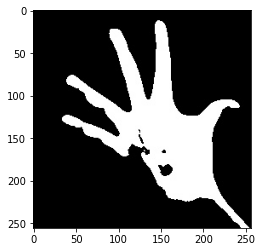

In [17]:
# 載入待檢測圖片
test_path = '/content/gdrive/My Drive/Colab Notebooks/HG/test/'
imageSrc = cv2.imread(test_path+ 'test3.jpg', 1)
#imageSrc = cv2.resize(imageSrc, (64,128))
plt.imshow(imageSrc)

(array([[ 85,  43,  83, 165]], dtype=int32), array([[2.1843338]]))


-1

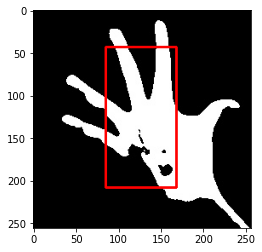

In [20]:
# 引數：(8,8)win滑動步長，(32,32)win大小，縮放係數 目標大小
objects = myHog.detectMultiScale(imageSrc, 0, (8,8), (32,32), 1.05, 2)
x = int(objects[0][0][0])
y = int(objects[0][0][1])
w = int(objects[0][0][2])
h = int(objects[0][0][3])
cv2.rectangle(imageSrc, (x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(imageSrc)
print(objects)
cv2.waitKey(0)

In [ ]:
#保存訓練結果
svm.save('/content/gdrive/My Drive/Colab Notebooks/HG/svm_data.dat')